#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Functions

In [2]:
def columns_all_zero(df, *, zero_tol=0.0,
                     treat_nan_as_zero=True,
                     require_non_nan=False,
                     return_labels=True):
    """
    Return columns where every value is (near-)zero, optionally treating NaNs as zero.

    Parameters
    ----------
    df : pandas.DataFrame
    zero_tol : float, default 0.0
        If >0, treat values with |x| <= zero_tol as zero.
    treat_nan_as_zero : bool, default True
        If True, NaNs are considered zero (i.e., they don't disqualify the column).
    require_non_nan : bool, default False
        If True, only return columns that have at least one non-NaN value.
        (Useful to exclude columns that are entirely NaN.)
    return_labels : bool, default True
        If True return column labels; else return 0-based indices.

    Returns
    -------
    list[str] | np.ndarray
    """
    # Base "is zero" mask (NaNs are False here; handled below)
    zero_mask = df.abs().le(zero_tol) if zero_tol > 0 else df.eq(0)

    if treat_nan_as_zero:
        zero_mask = zero_mask | df.isna()

    all_zero_like = zero_mask.all(axis=0)

    if require_non_nan:
        has_real_value = df.notna().any(axis=0)
        all_zero_like = all_zero_like & has_real_value

    return list(df.columns[all_zero_like]) if return_labels else np.flatnonzero(all_zero_like.to_numpy())

def columns_with_positive_runs(df, min_len=1, return_labels=False):
    """
    Return column indices (or labels) where there's a contiguous run of >0
    of length at least `min_len`.

    NaNs are treated as non-positive (they break runs).

    Parameters
    ----------
    df : pandas.DataFrame
    min_len : int, minimum run length (>=1)
    return_labels : bool, if True return column labels instead of indices

    Returns
    -------
    np.ndarray of ints (or list of labels if return_labels=True)
    """
    pos = df.gt(0)  # boolean mask; NaN -> False
    if min_len <= 1:
        ok = pos.any(axis=0)
    else:
        ok = pos.rolling(window=min_len, min_periods=min_len).sum().ge(min_len).any(axis=0)

    return list(df.columns[ok]) if return_labels else np.flatnonzero(ok.to_numpy())

def columns_with_isolated_peaks_no_runs(df, *, pos_threshold=0.0, zero_tol=0.0, return_labels=True):
    """
    Return columns that contain >=1 isolated peak [0, +, 0] and contain no runs
    of consecutive positive samples (length >= 2).

    Parameters
    ----------
    df : pandas.DataFrame
        Signal per column (rows = time/samples).
    pos_threshold : float, default 0.0
        Center must be strictly greater than this to be "positive".
    zero_tol : float, default 0.0
        Neighbors are considered zero if |value| <= zero_tol.
        (NaNs are treated as non-positive and not-zero; they break patterns.)
    return_labels : bool, default True
        If True return column labels; otherwise return 0-based column indices.

    Returns
    -------
    list[str] | np.ndarray
        Column labels (or indices) satisfying the condition.
    """
    # Booleans per cell
    pos = df.gt(pos_threshold).fillna(False)               # x > threshold
    zero = df.abs().le(zero_tol).fillna(False)             # |x| <= tol

    # Any positive runs (>=2 consecutive positives) → exclude
    has_run = (pos & pos.shift(1, fill_value=False)).any(axis=0)

    # Isolated peak [0, +, 0]: zero at i-1 and i+1, positive at i
    isolated_peak = zero.shift(1, fill_value=False) & pos & zero.shift(-1, fill_value=False)
    has_iso_peak = isolated_peak.any(axis=0)

    ok = (~has_run) & (has_iso_peak)

    return list(df.columns[ok]) if return_labels else np.flatnonzero(ok.to_numpy())

#### Inputs

In [3]:
csv_path = r'c:\Users\97254\Desktop\Resources\Technion\grad_school\shechtman_lap\projects\MS2\outputs\v2.4\gene_expression_results.csv'

In [4]:
df = pd.read_csv(csv_path)

In [5]:
df.head()

,timepoint,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,...,cell_798,cell_822,cell_829,cell_830,cell_831,cell_837,cell_839,cell_846,cell_847,cell_856
0,0,43.0,52.0,0.0,0.0,0.0,38.0,102.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,53.0,49.0,0.0,20.0,0.0,51.0,66.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,42.0,38.0,0.0,0.0,0.0,20.0,100.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,57.0,45.0,0.0,0.0,0.0,42.0,103.0,0.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
non_active_cells = columns_all_zero(df, zero_tol=0.0, treat_nan_as_zero=True, return_labels=True)
noisy_cells = columns_with_isolated_peaks_no_runs(df, pos_threshold=0.0, zero_tol=0.0, return_labels=True)
active_cells = columns_with_positive_runs(df, min_len=3, return_labels=True)

In [15]:
excluded_cells = set(non_active_cells) | set(noisy_cells) | set(active_cells)
mask = ~df.columns.isin(list(excluded_cells))
remaining_cells = list(df.columns[mask])

In [16]:
len(df.columns) == len(non_active_cells) + len(noisy_cells) + len(active_cells) + len(remaining_cells)

True

In [17]:
sorted_list = non_active_cells + noisy_cells + remaining_cells + active_cells
if time_col in sorted_list:
    sorted_list.remove(time_col)

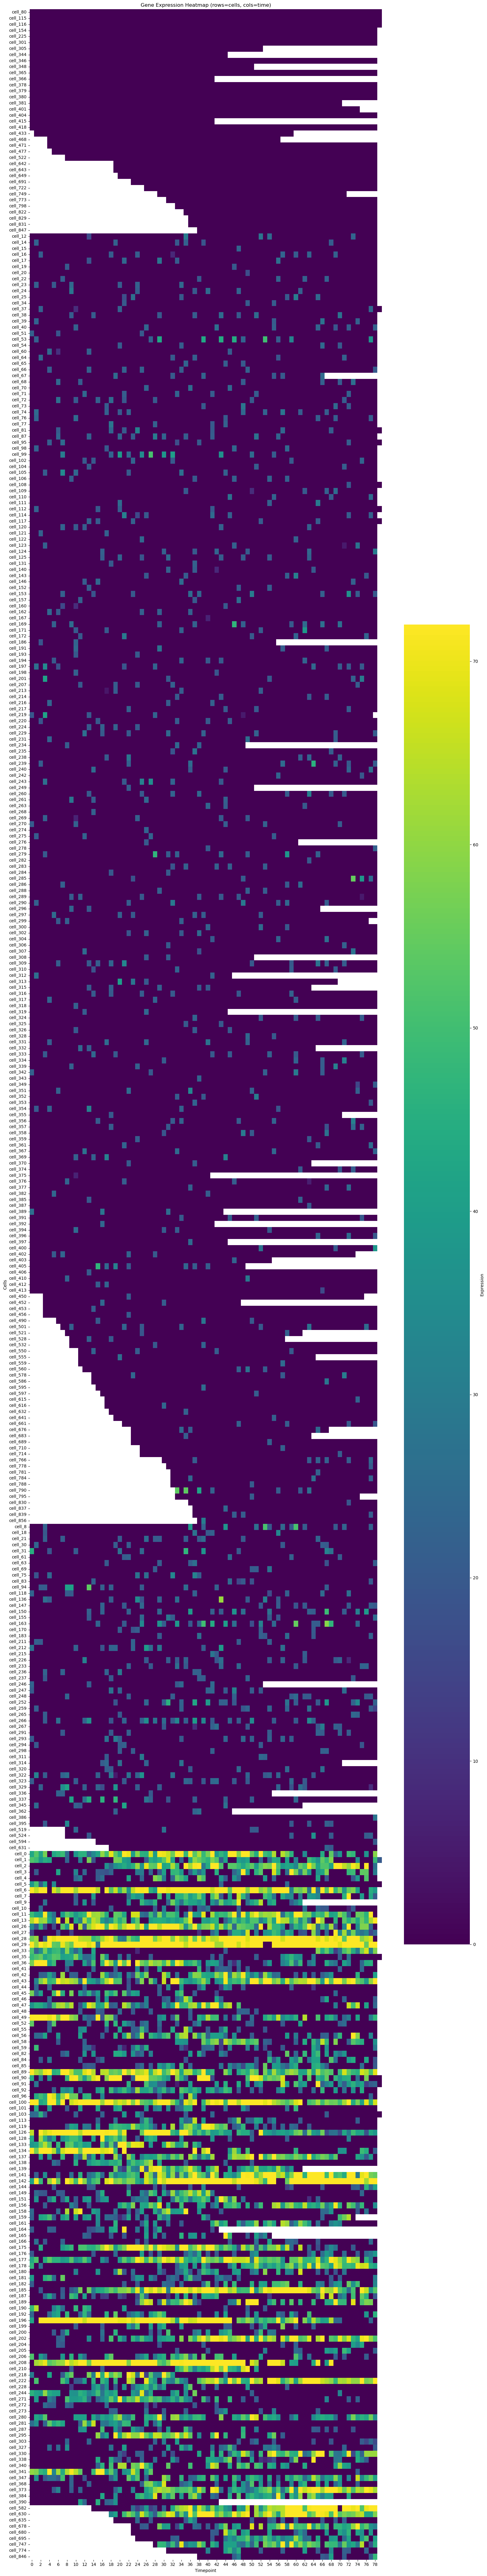

In [18]:
sorted_data = df.sort_values(time_col).set_index(time_col)[sorted_list]

# Flip axes: rows=cells, columns=timepoints
plt.figure(figsize=(max(12, sorted_data.shape[0] * 0.2), max(8, len(sorted_list) * 0.2)))
sns.heatmap(sorted_data.T, cmap="viridis", robust=True, cbar_kws={"label": "Expression"})
plt.title("Gene Expression Heatmap (rows=cells, cols=time)")
plt.xlabel("Timepoint")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()